In [ ]:
!pip install --quiet pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_palette('pastel')
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
from sklearn.metrics import mean_absolute_error
from scipy import stats
from scipy.stats import gamma, kstest
import statsmodels.api as sm
from pmdarima import auto_arima
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import xgboost as xgb

Haremos algo similar a lo que hicimos en el notebook comparandoModelos, es decir, obtendremos intervalos de confianza para el promedio del cross validation (backtesting) de los errores de distintos modelos. No obstante, ahora solo usaremos modelos que aceptan múltiples variables independientes para la predicción. En particular, consideraremos 16 variables obtenidas del Banco de Información Económica del INEGI:
1. ocupacion
2. actividad industrial
3. actividad turistica
4. actividad minera
5. formacion bruta de capital fijo
6. pib
7. ahorro
8. indicador global de la tasa económica
9. oferta global
10. demanda
11. consumo privado
12. formación bruta de capital fisico
13. indice de precios al consumidor
14. indice de precios al productor
15. balanza comercial - exportaciones
16. balanza comercial - importaciones

La ruta exacta de cada variables/conjunto de datos se encuentra en su documento csv correspondiente. Para todos los casos se usaron los datos desestacionalizados.

Aplicaremos redes neuronales LSTM y GRU, así como XGBoost.

###Cargamos datos de variable dependiente:

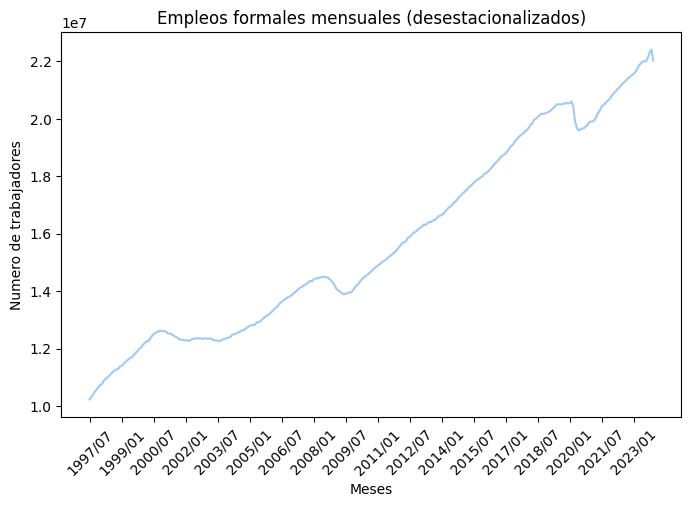

,Periodo,datos
0,1997/07,10228208
1,1997/08,10302942
2,1997/09,10402846


In [ ]:
dep = pd.read_csv('datosIMSS.csv') #variable dependiente
dep.set_index('Periodo', inplace=True) #para graficar
desest = [int(s.replace(',', '')) for s in dep.Desestacionalizados.values]
dep = dep.drop('Desestacionalizados', axis=1)
dep['datos'] = desest

plt.figure(figsize=(8, 5))
plt.title('Empleos formales mensuales (desestacionalizados)')
plt.xlabel('Meses')
plt.ylabel('Numero de trabajadores')
plt.plot(dep['datos'])
plt.xticks(dep.index[::18], rotation=45)
plt.show()

dep = dep.reset_index()
dep.head(3)

###Cargamos y preprocesamos datos vars indep:

In [ ]:
n = 16 #Número de variables a considerar, los datasets deben ser nombranos '1.csv, ..., n.csv'

In [ ]:
def find_data_start_stop(filename, encoding='utf-16-le'):
  '''
  Detectar cuando empieza el primer y último YYYY/MM en la primer columna y regresa estos indices
  '''
  start = None
  stop = None
  with open(filename, 'r', encoding=encoding) as file:
    for i, line in enumerate(file):
      if re.match(r'"?\d{4}/\d{2}"?,', line):
        if start is None:
          start = i
        stop = i
      elif start is not None:
        break
  return start, stop

In [ ]:
#En un diccionario guardamos los datos de cada variable
dicVars = {}
for i in range(1, n+1):
  filename = f'{i}.csv'
  start, stop = find_data_start_stop(filename)
  dicVars[i] = pd.read_csv(filename, skiprows=lambda x: x < start or x > stop,
                           encoding='utf-16-le', header=None, names=['Periodo', 'datos'])
  dicVars[i]['datos'] = dicVars[i]['datos'].replace('ND', np.nan)
  dicVars[i]['datos'] = dicVars[i]['datos'].astype(float)

Los valores nulos los reemplazaremos con un -1 pues normalizaremos los datos con MinMaxScaler, lo cual deja los datos en el intervalo [0,1]. Entonces nuestra red aprenderá a ignorar los -1.

In [ ]:
def preprocess_data(dicVars, startingDate, endingDate):
    startingDate_dt = pd.to_datetime(startingDate, format='%Y/%m')
    endingDate_dt = pd.to_datetime(endingDate, format='%Y/%m')
    for key, df in dicVars.items():
        df['Periodo'] = pd.to_datetime(df['Periodo'], format='%Y/%m')
        #Para la interpolación lineal para pasar las series trimestrales a mensuales:
        if not df['Periodo'].dt.month.isin([5]).any():
            def map_periodo_to_quarter(periodo):
                quarter_mapping = {1: 1, 2: 4, 3: 7, 4: 10}
                year, quarter = periodo.year, periodo.month
                start_month = quarter_mapping[quarter]
                aux = pd.Timestamp(year=year, month=start_month, day=1)
                return aux + pd.offsets.MonthEnd() #para que el día sea el último del mes y la interpolación lineal funcione
            df['Periodo'] = df['Periodo'].apply(map_periodo_to_quarter)
            df.set_index('Periodo', inplace=True)
            df = df.resample('M').interpolate(method='linear')
            df.reset_index(inplace=True)
        #Para recortar o llenar de -1 las series que se pasen o se queden cortas de la starting y ending Date de la variable dependiente
        if df['Periodo'].min() > startingDate_dt:
          if not (df['Periodo'].min().year == startingDate_dt.year and df['Periodo'].min().month == startingDate_dt.month):
            prepend_dates = pd.date_range(start=startingDate_dt, end=df['Periodo'].min(), inclusive='left', freq='M')
            prepend_df = pd.DataFrame({'Periodo': prepend_dates, 'datos': [-1] * len(prepend_dates)})
            df = pd.concat([prepend_df, df], ignore_index=True)
        else:
            df = df[df['Periodo'] >= startingDate_dt]
        if df['Periodo'].max() < endingDate_dt:
          if not (df['Periodo'].max().year == startingDate_dt.year and df['Periodo'].max().month == startingDate_dt.month):
            append_dates = pd.date_range(start=df['Periodo'].max() + pd.offsets.MonthBegin(), end=endingDate_dt + pd.offsets.MonthBegin(), inclusive='right', freq='M')
            append_df = pd.DataFrame({'Periodo': append_dates, 'datos': [-1] * len(append_dates)})
            df = pd.concat([df, append_df], ignore_index=True)
        else:
            df = df[df['Periodo'].dt.to_period('M') <= endingDate_dt.to_period('M')]
        dicVars[key] = df
    return dicVars

Aplicamos las transformaciones a las series de tiempo de variables independientes:

In [ ]:
startingDate = dep['Periodo'][0]
endingDate = dep['Periodo'].values[-1]

dicVars = preprocess_data(dicVars, startingDate, endingDate)

#Verificamos que tengan el mismo tamaño que la variable dependiente:
print(len(dep))
print('')
for i in range(len(dicVars.keys())):
  print(len(dicVars[i+1]))

318

318
318
318
318
318
318
318
318
318
318
318
318
318
318
318
318


Ahora juntemos todas las variables en un mismo Data Frame:

In [ ]:
df = pd.DataFrame({'Periodo': pd.to_datetime(dep.Periodo.values, format='%Y/%m'), 'y': dep.datos.values})
for i in range(len(dicVars.keys())):
  df[f'x{str(i+1)}'] = [-1] + list(dicVars[i+1].datos.values[:-1])
df['yLag1'] = [-1] + list(df['y'].values[:-1]) #agregamos la variable dep con un lag como independiente/predictora
df.set_index('Periodo', inplace=True)
df = df[[*df.columns[1:], df.columns[0]]] #para que 'y' quede al final
df = df.iloc[1:, :] #eliminamos el primer renglón
df

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,yLag1,y
Periodo,,,,,,,,,,,,,,,,,,
1997-08-01,-1.0,74.959354,64.711593,-1.000000,59.264720,1.569024e+07,1.024393e+06,64.546232,1.896156e+07,1.896156e+07,59.034121,59.264720,31.523211,-1.000000,9271.879048,9355.124621,10228208,10302942
1997-09-01,-1.0,76.574427,65.320142,-1.000000,60.934541,1.583743e+07,1.058420e+06,65.121202,1.914795e+07,1.914795e+07,59.740644,60.934541,31.803502,-1.000000,9230.583591,9378.092282,10302942,10402846
1997-10-01,-1.0,77.265716,65.928690,-1.000000,60.539493,1.598463e+07,1.092447e+06,65.415974,1.933434e+07,1.933434e+07,59.962380,60.539493,32.199613,-1.000000,9330.463560,9544.146171,10402846,10504875
1997-11-01,-1.0,77.736271,66.537239,-1.000000,60.800928,1.613182e+07,1.126473e+06,66.379688,1.952072e+07,1.952072e+07,60.593212,60.800928,32.456941,-1.000000,9541.501102,9646.101523,10504875,10571899
1997-12-01,-1.0,76.553174,66.866202,-1.000000,62.739104,1.621369e+07,1.149340e+06,66.954468,1.964659e+07,1.964659e+07,61.206039,62.739104,32.820042,-1.000000,9874.859962,9978.737195,10571899,10659265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,59167472.0,105.802382,104.094880,78.311998,115.080371,2.519413e+07,6.497006e+06,103.571603,3.648304e+07,3.648304e+07,107.255007,115.080371,128.832000,120.601434,-1.000000,-1.000000,22003674,21996854
2023-09-01,59246297.0,108.608839,-1.000000,74.715365,117.523868,2.520107e+07,-1.000000e+00,103.982581,-1.000000e+00,-1.000000e+00,107.870481,117.523868,129.545000,121.130502,-1.000000,-1.000000,21996854,22129453
2023-10-01,59325122.0,104.321467,-1.000000,78.243280,115.581096,2.520802e+07,-1.000000e+00,104.543505,-1.000000e+00,-1.000000e+00,108.775008,115.581096,130.120000,121.504194,-1.000000,-1.000000,22129453,22302738


In [ ]:
df.to_csv('variablesProcesadas.csv')

###Análisis de correlaciones:

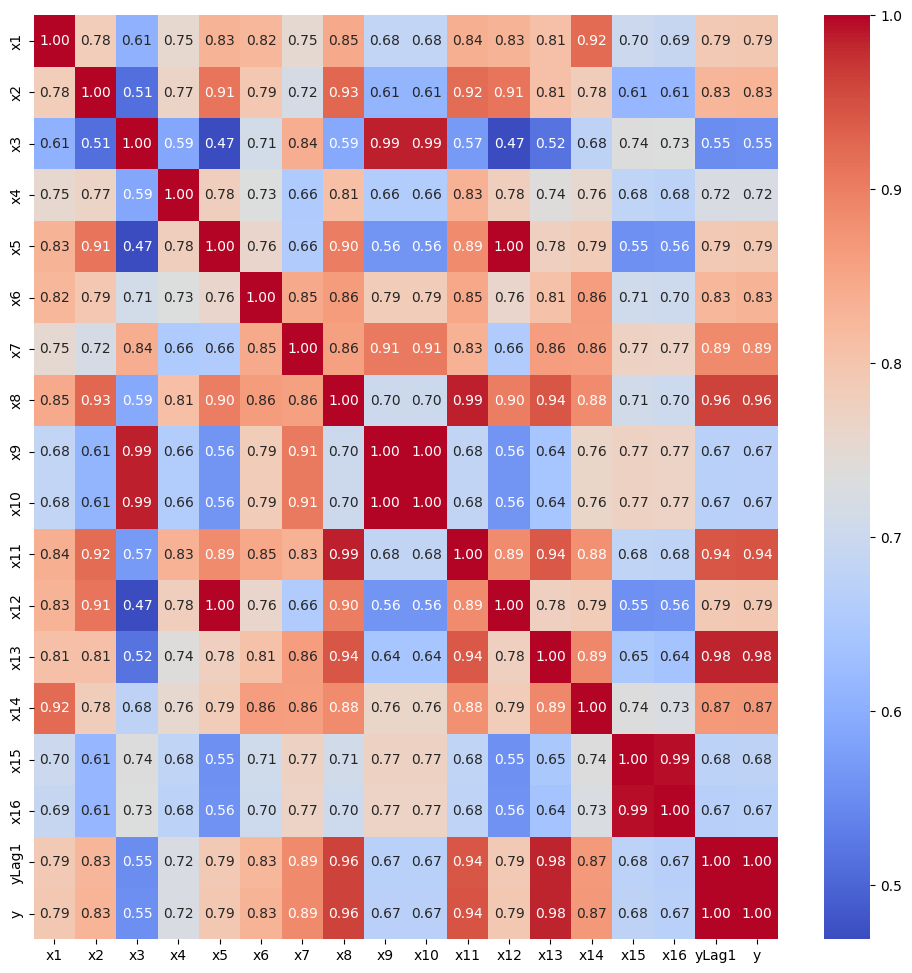

In [ ]:
corr_matrix = df.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

###Implementación y aplicación de modelo LSTM:

A diferencia del caso univariado, ahora consideraremos todas las fechas, incluso el periodo atípico de la pandemia del 2020, ya que al tratar los valores nan como -1, los casos atípicos también se van a -1 al obtener la primera diferencia de los datos escalados, por lo que esperamos que nuestro modelos aprenda a ignorar estaos casos.

In [ ]:
#cols_to_exclude = ['x3', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x13', 'x15']
cols_to_exclude = ['x14', 'x12', 'x3', 'x1', 'x6']
df = df.drop(columns=cols_to_exclude)

Text(0.5, 0, 'Fecha')

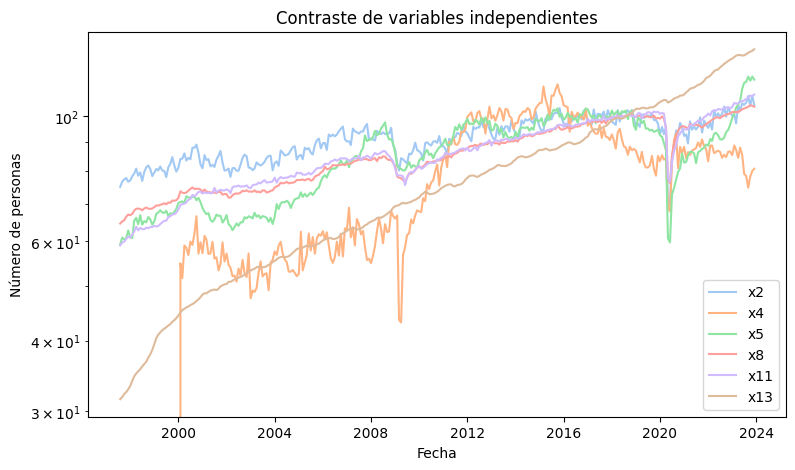

In [ ]:
plt.figure(figsize=(9, 5))
for i in df.columns:
  if df[i].max() < 1000:
    plt.plot(df[i], label=i)
plt.legend()
plt.yscale('log')
plt.title('Contraste de variables independientes')
plt.ylabel('Número de personas')
plt.xlabel('Fecha')

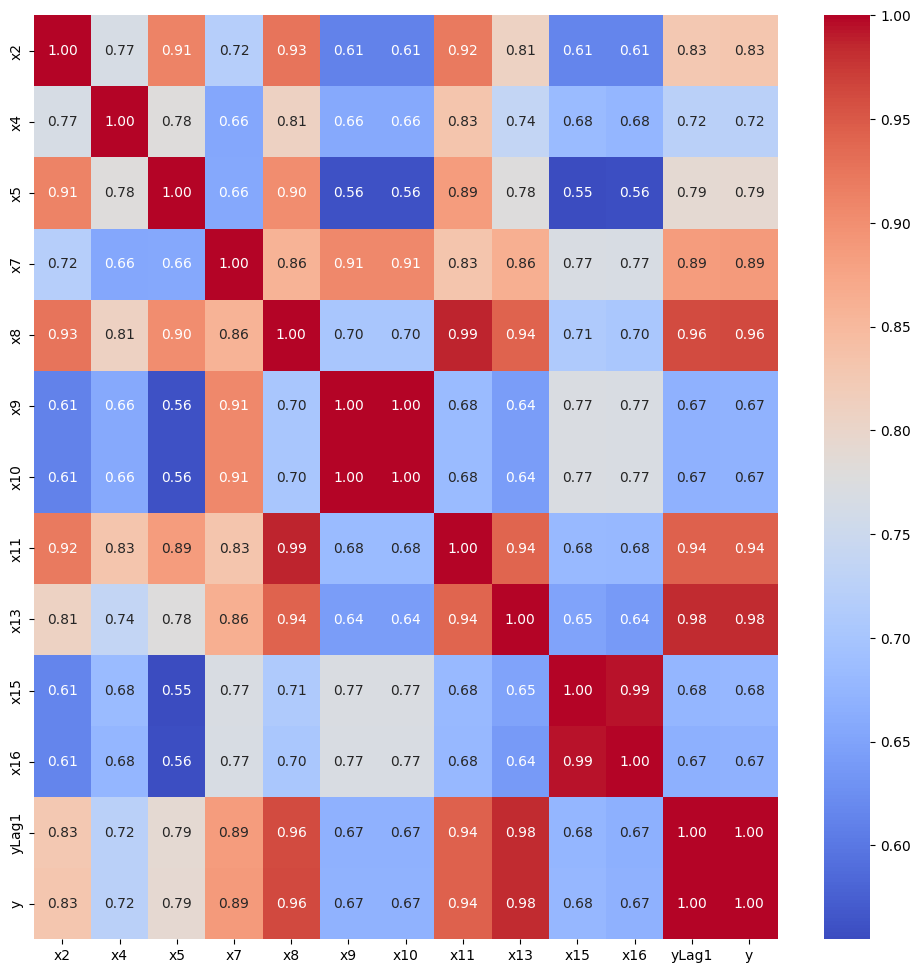

In [ ]:
corr_matrix = df.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

In [ ]:
#Definimos nuestros datos X y y, normalizamos, y sustituimos nulos por -1
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

X[X == -1] = np.nan

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_diff = np.diff(X, axis=0, prepend=np.array([X[0, :]]))
y_diff = np.diff(y, prepend=np.array([y[0]]))

X_scaled = scaler_X.fit_transform(X_diff)
y_scaled = scaler_y.fit_transform(y_diff.reshape(-1, 1))

X = np.nan_to_num(X_scaled, nan=-1)
y = np.nan_to_num(y_scaled, nan=-1).flatten()

In [ ]:
#Para las redes neuronales:
def create_sequences(input_data, output_data, input_sequence_length, output_sequence_length):
    X, y = [], []
    for i in range(len(input_data) - input_sequence_length - output_sequence_length + 1):
        X.append(input_data[i:(i + input_sequence_length)])
        y.append(output_data[(i + input_sequence_length):(i + input_sequence_length + output_sequence_length)])
    return np.array(X), np.array(y)

input_sequence_length = 24
output_sequence_length = 12

X_sequences, y_sequences = create_sequences(X[:-12], y[:-12], input_sequence_length, output_sequence_length)

In [ ]:
#Modelo
model = Sequential([
    LSTM(64, activation='relu', input_shape=(24, len(X[0])), return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dense(12)
])

model.compile(optimizer='adam', loss='mean_squared_error')

#Entrenamos
model.fit(X_sequences, y_sequences, epochs=100, batch_size=64, verbose=0)

In [ ]:
#Predecimos
xTest = X[-36:-12].reshape((1, 24, len(X[0])))
yTest = df.iloc[-12:, -1].values

yPred_diff = scaler_y.inverse_transform(model.predict(xTest)).flatten()
lastY = df.iloc[-13, -1]
yPred = np.r_[lastY, yPred_diff].cumsum()[1:]

1/1 [==============================] - 1s 540ms/step


In [ ]:
[np.abs(i-j) for i, j in zip(yPred, yTest)]

[29081.8671875,
 4635.26171875,
 33947.25390625,
 80297.31640625,
 86674.69140625,
 85398.55859375,
 43025.7421875,
 36873.5546875,
 34480.3671875,
 146739.74609375,
 177359.31640625,
 262109.984375]

In [ ]:
np.mean([np.abs(i-j) for i, j in zip(yPred, yTest)])

85051.9716796875

###Backtesting:

In [ ]:
def create_sequences(input_data, output_data, input_sequence_length, output_sequence_length):
    X, y = [], []
    for i in range(len(input_data) - input_sequence_length - output_sequence_length + 1):
        X.append(input_data[i:(i + input_sequence_length)])
        y.append(output_data[(i + input_sequence_length):(i + input_sequence_length + output_sequence_length)])
    return np.array(X), np.array(y)

In [ ]:
def backtest(data, modelName, nModels, minTrainSize, nAhead):
  '''
  data: es una serie de tiempo con las fechas como índice
  modelName: string del nombre del modelo, p.e 'ARIMA'
  nModels: es el número de modelos/periodos de tiempo a evaluar.
  minTrainSize: es el tamaño mínimo del conjunto de entrenamiento que estamos dispuestos a aceptar
  nAhead: numero de puntos/meses a predecir
  '''
  np.random.seed(0)
  fechas = data.reset_index().Periodo.values

  X = data.iloc[:, :-1].values
  y = data.iloc[:, -1].values

  X[X == -1] = np.nan

  scaler_X = MinMaxScaler()
  scaler_y = MinMaxScaler()

  X_diff = np.diff(X, axis=0, prepend=np.array([X[0, :]]))
  y_diff = np.diff(y, prepend=np.array([y[0]]))

  X_scaled = scaler_X.fit_transform(X_diff)
  y_scaled = scaler_y.fit_transform(y_diff.reshape(-1, 1))

  X = np.nan_to_num(X_scaled, nan=-1)
  y = np.nan_to_num(y_scaled, nan=-1).flatten()

  if minTrainSize>len(data) or (len(data)-minTrainSize)<(nAhead+nModels):
    print('No hay suficientes datos para tus requerimientos')
    return 0

  #Particionamos los datos en conjuntos de train y test:
  intsPartition = np.random.randint(minTrainSize, len(data)-nAhead, nModels)
  xTrains = []
  yTrains = []
  xTests = []
  lastYs = []
  yTests = []
  trainDates = [] #para ver los periodos en los que estamos teniendo predicciones atípicas
  for i in intsPartition:
    xTrains.append(X[:i])
    yTrains.append(y[:i])
    trainDates.append(fechas[:i])
    xTests.append(X[i-24:i].reshape((1, 24, len(X[0]))))
    lastYs.append(data.iloc[i-1, -1])
    yTests.append(data.iloc[i:i+12, -1])
    #yTests.append(np.r_[lastY, yPred_diff].cumsum()[1:])

  #Aplicamos el modelo elegido por el usuario y creamos una matriz de len(nModels)xlen(nAhead) con los errores
  errores = []
  if True: #if modelName == 'LSTM'
    for xTrain, yTrain, xTest, lastY, yTest in zip(xTrains, yTrains, xTests, lastYs, yTests):
      #Particionamos los datos para la red LSTM
      input_sequence_length = 24
      output_sequence_length = 12
      X_sequences, y_sequences = create_sequences(xTrain, yTrain, input_sequence_length, output_sequence_length)

      #Modelo
      model = Sequential([
      modelName(64, activation='relu', input_shape=(24, len(X[0])), return_sequences=True),
      Dropout(0.2),
      modelName(32, activation='relu'),
      Dense(12)])

      model.compile(optimizer='adam', loss='mean_squared_error')

      #Entrenamos
      model.fit(X_sequences, y_sequences, epochs=100, batch_size=64, verbose=0)

      #Predecimos
      yPred_diff = scaler_y.inverse_transform(model.predict(xTest)).flatten()
      yPred = np.r_[lastY, yPred_diff].cumsum()[1:]

      #Estimamos error
      errores.append([np.abs(i-j) for i, j in zip(yPred, yTest)])
  return errores

In [ ]:
def createLaggedFeatures(data, lag): #para el xgboost
  for i in range(1, lag + 1):
    data[f'lag_{i}'] = data['target'].shift(-i)
  data.dropna(inplace=True)
  return data

In [ ]:
def backtestEnsemble(data, modelos, nModels, minTrainSize, nAhead):
  '''
  data: es una serie de tiempo con las fechas como índice
  modelos: tupla ('ARIMA', 'Holt')
  nModels: es el número de modelos/periodos de tiempo a evaluar.
  minTrainSize: es el tamaño mínimo del conjunto de entrenamiento que estamos dispuestos a aceptar
  nAhead: numero de puntos/meses a predecir
  '''
  np.random.seed(0)
  #Escalamos los datos:
  scaler = MinMaxScaler()
  data1 = data.values #para TCMA pues si no se hace muy pequeño
  fechas = data.reset_index().Periodo.values
  data = scaler.fit_transform(data.values.reshape(-1 ,1)).flatten()

  if minTrainSize>len(data) or (len(data)-minTrainSize)<(nAhead+nModels):
    print('No hay suficientes datos para tus requerimientos')
    return 0

  #Particionamos los datos en conjuntos de train y test:
  intsPartition = np.random.randint(minTrainSize, len(data)-nAhead, nModels)
  trainSets1 = []
  testSets1 = []
  trainDates1 = [] #para ver los periodos en los que estamos teniendo predicciones atípicas

  trainSets2 = []
  testSets2 = []
  trainDates2 = []

  #para ARIMA y TCMA
  for i in intsPartition:
    trainSets1.append(data1[:i])
    trainDates1.append(fechas[:i])
    testSets1.append(data1[i:i+nAhead])

  #Para Holt y XGBoost
  for i in intsPartition:
    trainSets2.append(data[:i])
    trainDates2.append(fechas[:i])
    testSets2.append(scaler.inverse_transform(data[i:i+nAhead].reshape(-1 ,1)).flatten())

  #Aplicamos el modelo elegido por el usuario y creamos una matriz de len(nModels)xlen(nAhead) con los errores
  errores = []
  for train, test in zip(trainSets1, testSets1) if set(modelos)=={'TCMA', 'ARIMA'} else zip(trainSets2, testSets2):
    predsModelos = []
    if 'TCMA' in modelos:
      #TCMA
      _, trend = sm.tsa.filters.hpfilter(train)
      tcma = (trend[-1]/trend[0])**(1/len(trend))-1
      predsModelos.append(np.array([trend[-1]*((tcma+1)**(i+1)) for i in range(nAhead)]))

    if 'ARIMA' in modelos:
      #ARIMA
      last = train[-1]
      train = np.diff(train)
      model = auto_arima(train)
      predARIMA = model.predict(n_periods=nAhead, return_conf_int=False)
      predsModelos.append(np.array([last+np.sum(predARIMA[:i+1]) for i in range(len(predARIMA))]))

    if 'Holt' in modelos:
      model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=4, trend='add')
      model_fit = model.fit()
      pred = model_fit.forecast(steps=nAhead)
      predsModelos.append(scaler.inverse_transform(pred.reshape(-1 ,1)).flatten())

    if 'XGBoost' in modelos:
      last = train[-1]
      train = np.diff(train)
      df = pd.DataFrame({'target': train})
      lags = 24
      data = createLaggedFeatures(df, lags)
      X = data.drop('target', axis=1).values
      y = data['target'].values
      model = xgb.XGBRegressor()
      model.fit(X, y)
      pred = []
      Xtest = np.append(X[-1, 1:], y[-1])
      for i in range(nAhead):
        pred.append(model.predict(Xtest.reshape(1, -1)))
        Xtest = np.append(Xtest[1:], pred[-1])
      pred = np.array([last+np.sum(pred[:i+1]) for i in range(len(pred))]).reshape(-1, 1)
      predsModelos.append(scaler.inverse_transform(pred).flatten())

    #Ensamble
    pred = [(a + b) / 2 for a, b in zip(predsModelos[0], predsModelos[1])]
    errores.append(list(np.abs(pred-test)))

  return np.array(errores)#, trainDates

In [ ]:
def graficaErrores(errores, modelo, nModelos=10):
  overallMean = np.mean(errores)
  overallStd = np.std(errores)
  plt.figure(figsize=(8, 5))
  for i in range(nModelos):
    if nModelos==10:
      plt.plot(errores[i], label=f'Modelo {i}')
    else:
      plt.plot(errores[i])
  plt.title(f'Errores en predicciones con {modelo}')
  plt.xlabel('Meses en adelante predichos')
  plt.ylabel('Error')
  plt.legend()
  annotation = f'Media: {overallMean:.3f}\nDesviación estándar: {overallStd:.3f}'
  plt.annotate(annotation, xy=(0, 0), xytext=(-0.05, -0.25), fontsize=10, textcoords='axes fraction', color='gray')
  file_path = f"/content/{modelo}.png"
  plt.savefig(file_path)
  plt.show()

In [ ]:
#nModelos = 10
#errores = backtest(df, GRU, nModelos, 200, 12)

In [ ]:
#graficaErrores(errores, 'GRU', nModelos)

In [ ]:
nModelos = 100
errores = backtest(df, GRU, nModelos, 200, 12)

In [ ]:
def toNorm(errs, nSamples, nMeans): #usa el TCL para obtener nMeans muestras de tamaño nSamples y promediarlas (estandarizando obtenemos ajustes menos precisos por error de redondeo).
  means = []
  for i in range(nMeans):
    means.append(np.mean(np.random.choice(errs, size=nSamples, replace=True)))
    #means.append((np.mean(np.random.choice(errs, size=nSamples, replace=True))-np.mean(errs))/(np.std(errs)))
  return means

In [ ]:
def intervalos(errores):
  X = toNorm(np.array(errores).flatten(), 30, 10000)
  _, shapiro = stats.shapiro(X)
  print(f'\n{shapiro} (menor a 0.05 entonces no es normal)')
  a, loc, b=stats.gamma.fit(X)
  print(f'{kstest(X, "gamma", args=(a, loc, b))} \n(p-valor mayor a 0.05 evidencia de que es gamma)')

  n = 30
  confLevel = 0.95

  #SEM: standard error of the mean
  sem = np.std(X)/np.sqrt(n)

  #Critical value de la t-distribution
  #n-1 degrees of freedom para una muestra de tamaño n
  t_critical = stats.t.ppf((1 + confLevel) / 2, df=n - 1, )

  margin_of_error = t_critical * sem

  #Confidence interval para la media
  mean = a * b + loc  #Media
  confInt = (mean - margin_of_error, mean + margin_of_error)
  print(f'\nIntervalo de confianza: {confInt}')

In [ ]:
intervalos(errores) #GRU


3.1231457621581265e-23 (menor a 0.05 entonces no es normal)
KstestResult(statistic=0.009092969552345731, pvalue=0.37777722791812085, statistic_location=264561.29669189453, statistic_sign=-1) 
(p-valor mayor a 0.05 evidencia de que es gamma)

Intervalo de confianza: (226951.8614371831, 264297.5227193327)


In [ ]:
nModelos = 100
errores2 = backtestEnsemble(df['y'], ('TCMA', 'ARIMA'), nModelos, 200, 12)

intervalos(errores2) #Ensamble TCMA-ARIMA


2.0073738239498788e-26 (menor a 0.05 entonces no es normal)
KstestResult(statistic=0.0073893012043490525, pvalue=0.6430256377833572, statistic_location=198954.97519287455, statistic_sign=-1) 
(p-valor mayor a 0.05 evidencia de que es gamma)

Intervalo de confianza: (188444.61774184505, 227069.0692692241)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [ ]:
nModelos = 100
errores3 = backtestEnsemble(df['y'], ('Holt', 'XGBoost'), nModelos, 200, 12)

intervalos(errores3) #Ensamble Holt-XGBoost


9.92926217522703e-26 (menor a 0.05 entonces no es normal)
KstestResult(statistic=0.0057491617780353055, pvalue=0.8937020700295852, statistic_location=202705.7845966153, statistic_sign=-1) 
(p-valor mayor a 0.05 evidencia de que es gamma)

Intervalo de confianza: (170838.68535836056, 212453.83573792587)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
